In [1]:
import keras
#keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
from keras.applications.densenet import DenseNet121
#from tensorflow.keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def Densenet121(show_layers,weights,input_shape):
        base_model = DenseNet121(include_top=False, weights=weights, input_shape=input_shape)
        x = GlobalAveragePooling2D()(base_model.output)
        pred = Dense(1, activation='sigmoid')(x)
    
        model = Model(inputs=base_model.input, outputs=pred)
        model.compile(optimizer=SGD(lr=1e-3, decay=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
        if show_layers:
            for i, layer in enumerate(model.layers):
                print(i, layer.name, layer.trainable)
        return model
    
model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

model.summary()

Using TensorFlow backend.
W0317 17:44:16.918115  8824 deprecation_wrapper.py:119] From C:\Users\prlab\anaconda3\envs\bjy\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0317 17:44:16.962572  8824 deprecation_wrapper.py:119] From C:\Users\prlab\anaconda3\envs\bjy\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0317 17:44:16.996336  8824 deprecation_wrapper.py:119] From C:\Users\prlab\anaconda3\envs\bjy\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0317 17:44:17.028026  8824 deprecation_wrapper.py:119] From C:\Users\prlab\anaconda3\envs\bjy\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session inst

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

# protocol_1

# TOP

- 학습

>>  T_angle
============================================Densenet121=============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
train shape : (13680,)
Epoch 1/100
1710/1710 [==============================] - 272s 159ms/step - loss: 0.3271 - acc: 0.8633 - val_loss: 1.0365 - val_acc: 0.6913

Epoch 00001: val_loss improved from inf to 1.03652, saving model to C:\Users\prlab\Desktop\ysg\result_angle\T_angle-01-1.0365.hdf5
Epoch 2/100
1710/1710 [==============================] - 253s 148ms/step - loss: 0.1819 - acc: 0.9325 - val_loss: 0.6303 - val_acc: 0.7835

Epoch 00002: val_loss improved from 1.03652 to 0.63025, saving model to C:\Users\prlab\Desktop\ysg\result_angle\T_angle-02-0.6303.hdf5
Epoch 3/100
1710/1710 [==============================] - 254s 148ms/step - loss: 0.1269 - acc: 0.9576 - val_loss: 0.3890 - val_acc: 0.8426

Epoch 00003: val_loss improved from 0.63025 to 0.38896, saving model to C:\Users\prlab\Deskt

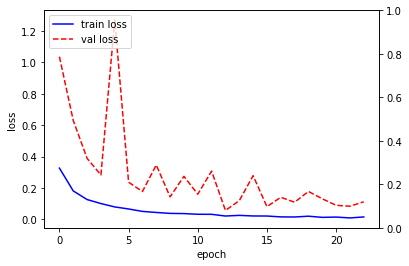

acc: 0.9787	loss: 0.0578
==========================================T_angle finished==========================================


In [5]:
#### import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\ysg\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'T_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'T_angle'
    
    saveDir =  'C:\\Users\\prlab\\Desktop\\ysg\\result_angle'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>> model loaded: T_angle-13-0.0578.hdf5
>>>> evaluating on 'T_angle'
Found 10080 images belonging to 2 classes.
Found 18720 images belonging to 2 classes.
                  pred_fake(0)   pred_real(1)
actural_fake(0)           12226            254
actual_real(1)             127           6113

EER: 0.0196	HTER: 0.0204
>> finished


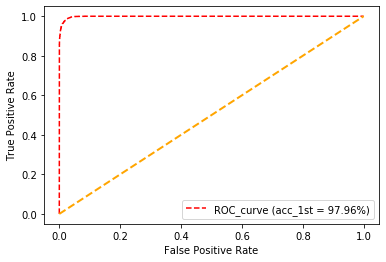

<Figure size 432x288 with 0 Axes>

In [6]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'T_angle'
    testDB = 'T_angle'
    
    dataDir = 'C:\\Users\\prlab\\Desktop\\ysg\\protocol_1'
    modelPath = 'C:\\Users\\prlab\\Desktop\\ysg\\result_angle\\T_angle-13-0.0578.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

# middle

- 학습

>>  M_angle
============================================Densenet121=============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
train shape : (13680,)
Epoch 1/100
1710/1710 [==============================] - 271s 159ms/step - loss: 0.3601 - acc: 0.8506 - val_loss: 0.5410 - val_acc: 0.7737

Epoch 00001: val_loss improved from inf to 0.54103, saving model to C:\Users\prlab\Desktop\ysg\result_angle\M_angle-01-0.5410.hdf5
Epoch 2/100
1710/1710 [==============================] - 261s 152ms/step - loss: 0.2081 - acc: 0.9230 - val_loss: 1.8023 - val_acc: 0.6982

Epoch 00002: val_loss did not improve from 0.54103
Epoch 3/100
1710/1710 [==============================] - 260s 152ms/step - loss: 0.1484 - acc: 0.9452 - val_loss: 1.0985 - val_acc: 0.7289

Epoch 00003: val_loss did not improve from 0.54103
Epoch 4/100
1710/1710 [==============================] - 258s 151ms/step - loss: 0.1156 - acc: 0.9602 - val_loss: 0.6144 - va

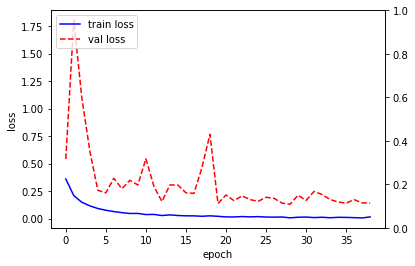

acc: 0.9664	loss: 0.1300
==========================================M_angle finished==========================================


In [7]:
#### import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\ysg\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'M_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'M_angle'
    
    saveDir =  'C:\\Users\\prlab\\Desktop\\ysg\\result_angle'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

- test

>> model loaded: M_angle-29-0.1300.hdf5
>>>> evaluating on 'M_angle'
Found 10080 images belonging to 2 classes.
Found 18720 images belonging to 2 classes.
                  pred_fake(0)   pred_real(1)
actural_fake(0)           12044            436
actual_real(1)             218           6022

EER: 0.0367	HTER: 0.0349
>> finished


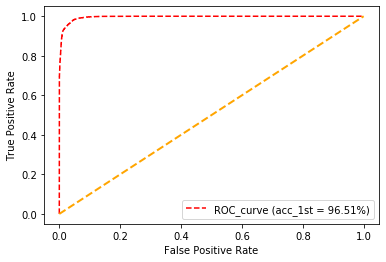

<Figure size 432x288 with 0 Axes>

In [9]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'M_angle'
    testDB = 'M_angle'
    
    dataDir = 'C:\\Users\\prlab\\Desktop\\ysg\\protocol_1'
    modelPath = 'C:\\Users\\prlab\\Desktop\\ysg\\result_angle\\M_angle-29-0.1300.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

# Bottom

- 학습

>>  B_angle
============================================Densenet121=============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
train shape : (13680,)
Epoch 1/100
1710/1710 [==============================] - 273s 160ms/step - loss: 0.3189 - acc: 0.8727 - val_loss: 0.5921 - val_acc: 0.7610

Epoch 00001: val_loss improved from inf to 0.59215, saving model to C:\Users\prlab\Desktop\ysg\result_angle\B_angle-01-0.5921.hdf5
Epoch 2/100
1710/1710 [==============================] - 261s 153ms/step - loss: 0.1262 - acc: 0.9583 - val_loss: 1.0843 - val_acc: 0.6845

Epoch 00002: val_loss did not improve from 0.59215
Epoch 3/100
1710/1710 [==============================] - 261s 153ms/step - loss: 0.0721 - acc: 0.9813 - val_loss: 1.8806 - val_acc: 0.6839

Epoch 00003: val_loss did not improve from 0.59215
Epoch 4/100
1710/1710 [==============================] - 262s 153ms/step - loss: 0.0567 - acc: 0.9830 - val_loss: 0.1768 - va

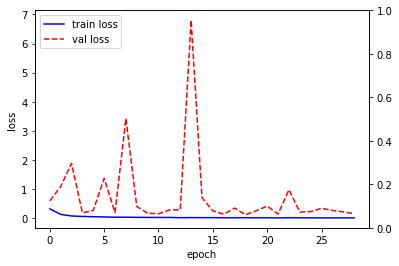

acc: 0.9583	loss: 0.1145
==========================================B_angle finished==========================================


In [10]:
#### import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\ysg\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'B_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'B_angle'
    
    saveDir =  'C:\\Users\\prlab\\Desktop\\ysg\\result_angle'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

- test

>> model loaded: B_angle-19-0.1145.hdf5
>>>> evaluating on 'B_angle'
Found 10080 images belonging to 2 classes.
Found 18720 images belonging to 2 classes.
                  pred_fake(0)   pred_real(1)
actural_fake(0)           12048            432
actual_real(1)             216           6024

EER: 0.0427	HTER: 0.0346
>> finished


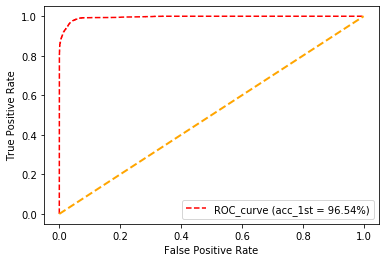

<Figure size 432x288 with 0 Axes>

In [12]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'B_angle'
    testDB = 'B_angle'
    
    dataDir = 'C:\\Users\\prlab\\Desktop\\ysg\\protocol_1'
    modelPath = 'C:\\Users\\prlab\\Desktop\\ysg\\result_angle\\B_angle-19-0.1145.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

# protocol_2

# near

- 학습

>>  N_distance
============================================Densenet121=============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
train shape : (13680,)
Epoch 1/100
1710/1710 [==============================] - 283s 166ms/step - loss: 0.3556 - acc: 0.8474 - val_loss: 0.3832 - val_acc: 0.8419

Epoch 00001: val_loss improved from inf to 0.38316, saving model to C:\Users\prlab\Desktop\ysg\result_distance\N_distance-01-0.3832.hdf5
Epoch 2/100
1710/1710 [==============================] - 261s 153ms/step - loss: 0.1948 - acc: 0.9268 - val_loss: 1.5698 - val_acc: 0.6794

Epoch 00002: val_loss did not improve from 0.38316
Epoch 3/100
1710/1710 [==============================] - 263s 154ms/step - loss: 0.1615 - acc: 0.9389 - val_loss: 0.3545 - val_acc: 0.8590

Epoch 00003: val_loss improved from 0.38316 to 0.35454, saving model to C:\Users\prlab\Desktop\ysg\result_distance\N_distance-03-0.3545.hdf5
Epoch 4/100
1710/1710 [===

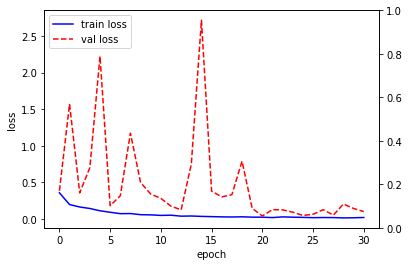

acc: 0.9873	loss: 0.0389
========================================N_distance finished=========================================


In [13]:
#### import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\ysg\\protocol_2'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'N_distance'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'N_distance'
    
    saveDir =  'C:\\Users\\prlab\\Desktop\\ysg\\result_distance'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

- test

>> model loaded: N_distance-21-0.0389.hdf5
>>>> evaluating on 'N_distance'
Found 10080 images belonging to 2 classes.
Found 18720 images belonging to 2 classes.
                  pred_fake(0)   pred_real(1)
actural_fake(0)           12163            317
actual_real(1)             160           6080

EER: 0.0149	HTER: 0.0255
>> finished


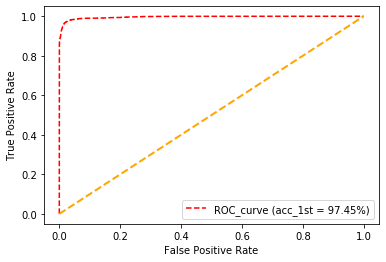

<Figure size 432x288 with 0 Axes>

In [14]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'N_distance'
    testDB = 'N_distance'
    
    dataDir = 'C:\\Users\\prlab\\Desktop\\ysg\\protocol_2'
    modelPath = 'C:\\Users\\prlab\\Desktop\\ysg\\result_distance\\N_distance-21-0.0389.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

# D_distance

- 학습

>>  D_distance
============================================Densenet121=============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
train shape : (13680,)
Epoch 1/100
1710/1710 [==============================] - 274s 160ms/step - loss: 0.3928 - acc: 0.8283 - val_loss: 0.2968 - val_acc: 0.8884

Epoch 00001: val_loss improved from inf to 0.29677, saving model to C:\Users\prlab\Desktop\ysg\result_distance\D_distance-01-0.2968.hdf5
Epoch 2/100
1710/1710 [==============================] - 261s 153ms/step - loss: 0.2489 - acc: 0.9015 - val_loss: 0.9626 - val_acc: 0.7023

Epoch 00002: val_loss did not improve from 0.29677
Epoch 3/100
1710/1710 [==============================] - 261s 153ms/step - loss: 0.1975 - acc: 0.9250 - val_loss: 0.3520 - val_acc: 0.8708

Epoch 00003: val_loss did not improve from 0.29677
Epoch 4/100
1710/1710 [==============================] - 261s 153ms/step - loss: 0.1527 - acc: 0.9436 - val_loss: 1.

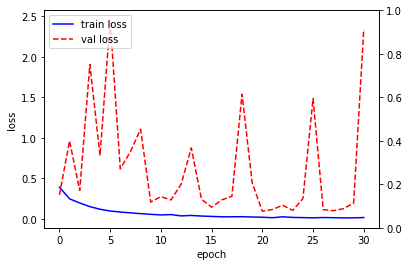

acc: 0.9722	loss: 0.0951
========================================D_distance finished=========================================


In [15]:
#### import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\ysg\\protocol_2'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'D_distance'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'D_distance'
    
    saveDir =  'C:\\Users\\prlab\\Desktop\\ysg\\result_distance'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

- test

>> model loaded: D_distance-21-0.0951.hdf5
>>>> evaluating on 'D_distance'
Found 10080 images belonging to 2 classes.
Found 18720 images belonging to 2 classes.
                  pred_fake(0)   pred_real(1)
actural_fake(0)           11969            511
actual_real(1)             254           5986

EER: 0.0283	HTER: 0.0408
>> finished


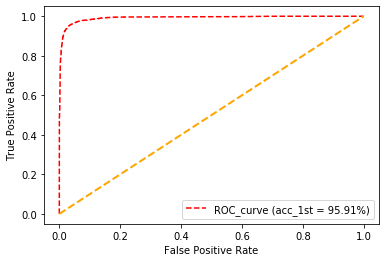

<Figure size 432x288 with 0 Axes>

In [18]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'D_distance'
    testDB = 'D_distance'
    
    dataDir = 'C:\\Users\\prlab\\Desktop\\ysg\\protocol_2'
    modelPath = 'C:\\Users\\prlab\\Desktop\\ysg\\result_distance\\D_distance-21-0.0951.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()